In [1]:
from src.libs.lib import *
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


Hash numérica de 5 dígitos: 94799


In [2]:
dfs = load_data_db()
#48.5s

Conexão estabelecida com sucesso!


In [ ]:
TIPO = "Ajudante"

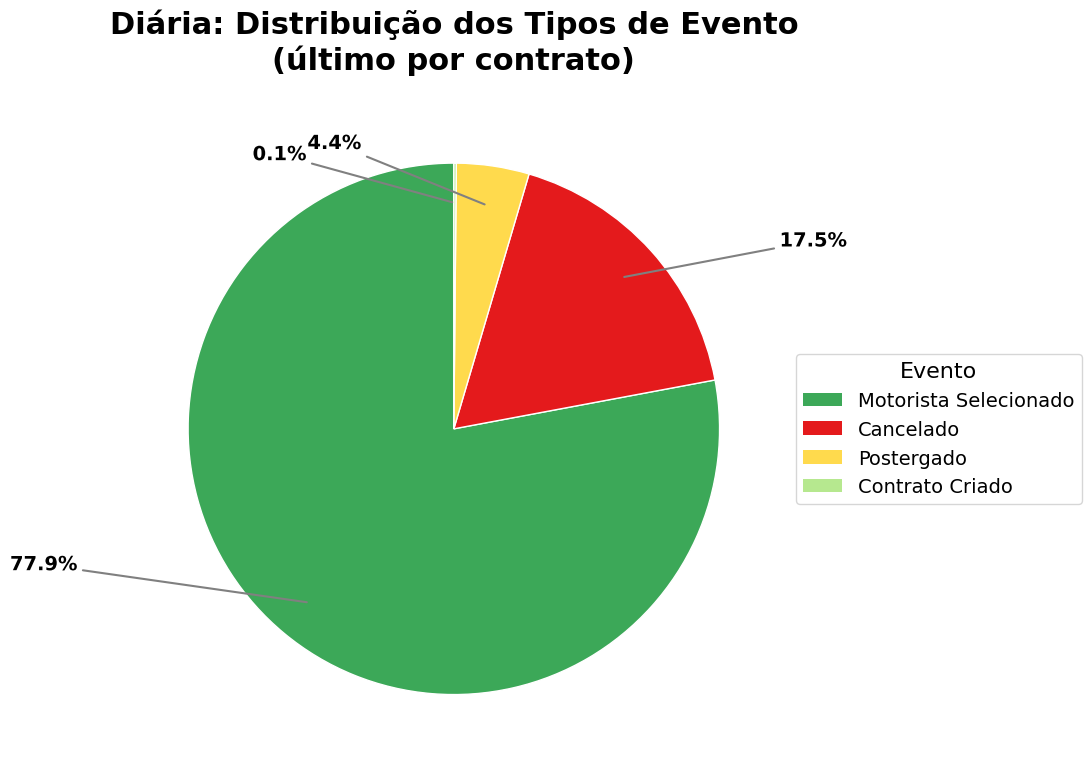

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.patheffects as path_effects
import numpy as np

# Dados
df = dfs["B - timeline"].copy()
df['event_date'] = pd.to_datetime(df['event_date'], errors='coerce')
df_last = df.sort_values('event_date').groupby('id').tail(1)

# Contagem
contagem_eventos = df_last['event_name'].value_counts()
labels = contagem_eventos.index.tolist()
valores = contagem_eventos.values
total = valores.sum()

# Cores e nomes
cores_eventos = {
    'freight_created': '#b6e88f',
    'start_at_change': '#ffda4d',
    'canceled': '#e41a1c',
    'has_driver': '#3ca858'
}
nomes_portugues = {
    'freight_created': 'Contrato Criado',
    'has_driver': 'Motorista Selecionado',
    'start_at_change': 'Postergado',
    'canceled': 'Cancelado'
}
cores = [cores_eventos[label] for label in labels]
labels_pt = [nomes_portugues[label] for label in labels]

# Gráfico
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(12, 8))
wedges, texts = ax.pie(
    valores,
    labels=None,
    startangle=90,
    colors=cores,
    wedgeprops={'edgecolor': 'white'},
)



for i, (wedge, val) in enumerate(zip(wedges, valores)):
    ang = (wedge.theta2 + wedge.theta1) / 2.
    
    # Coordenadas da seta (fixas, centradas na fatia)
    x = np.cos(np.deg2rad(ang))
    y = np.sin(np.deg2rad(ang))
    xy = (x * 0.85, y * 0.85)

    # Inclinação aleatória só para o ponto de texto
    desvio = np.random.uniform(-30, 30)
    ang_inclinado = ang + desvio
    x_txt = np.cos(np.deg2rad(ang_inclinado))
    y_txt = np.sin(np.deg2rad(ang_inclinado))
    xytext = (x_txt * 1.6, y_txt * 1.1)

    ha = 'left' if x_txt > 0 else 'right'

    ax.annotate(
        f"{(val/total)*100:.1f}%",
        xy=xy,
        xytext=xytext,
        textcoords='data',
        ha=ha, va='center',
        fontsize=14,
        fontweight='bold',
        color='black',
        path_effects=[path_effects.withStroke(linewidth=2, foreground='white')],
        arrowprops=dict(arrowstyle='-', color='gray', lw=1.5)
    )

# Legenda
legend_patches = [
    Patch(facecolor=cores[i], label=labels_pt[i])
    for i in range(len(labels_pt))
]
ax.legend(
    handles=legend_patches,
    title='Evento',
    title_fontsize=16,
    fontsize=14,
    loc='center left',
    bbox_to_anchor=(1, 0.5)
)

ax.set_title(
    f'{TIPO}: Distribuição dos Tipos de Evento\n(último por contrato)',
    fontsize=22,
    fontweight='bold',
    pad=20
)

plt.tight_layout()
plt.show()


/tmp/ipykernel_11791/1490308177.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_final.groupby(['janela', 'event_name'])


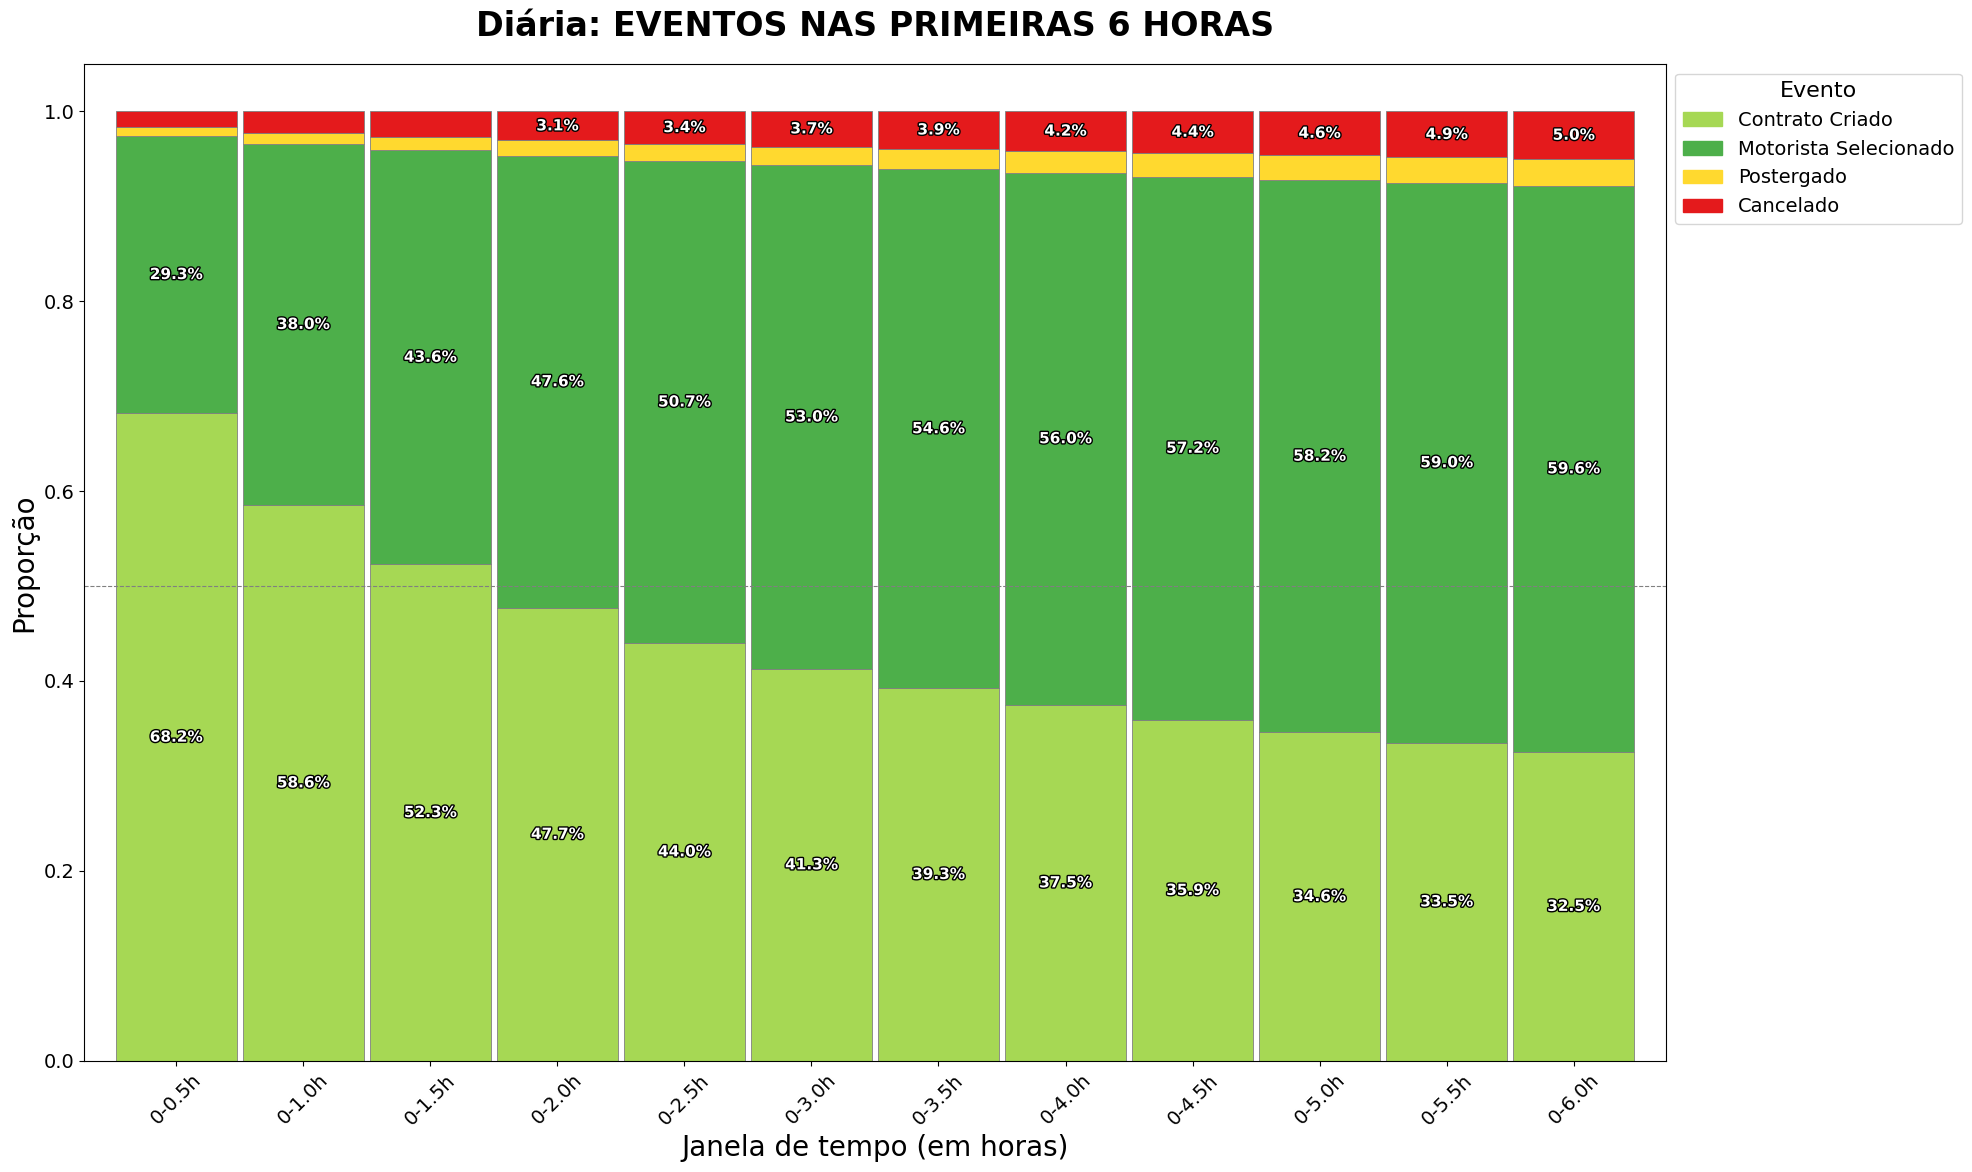

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

# ─── Dados ───
df = dfs["B - timeline"].copy()
df['created_at'] = pd.to_datetime(df['created_at'])
df['event_date'] = pd.to_datetime(df['event_date'])
df['tempo_decorrido'] = pd.to_numeric(df['tempo_decorrido'], errors='coerce')

# ─── Janelas de tempo (0.5h a 6.0h) ───
janelas_horas = np.arange(0.5, 6.5, 0.5).round(2)
df_resultados = []

for h in janelas_horas:
    df_janela = df[df['tempo_decorrido'] <= h].copy()
    df_ultimos = df_janela.sort_values('event_date').groupby('id').tail(1)
    df_ultimos['janela'] = f'0-{h}h'
    df_resultados.append(df_ultimos)

df_final = pd.concat(df_resultados, ignore_index=True)
ordem_janelas = [f'0-{h}h' for h in janelas_horas]
df_final['janela'] = pd.Categorical(df_final['janela'], categories=ordem_janelas, ordered=True)

# ─── Proporções ───
tabela_proporcao = (
    df_final.groupby(['janela', 'event_name'])
    .size()
    .unstack(fill_value=0)
    .loc[ordem_janelas]
)
tabela_pct = tabela_proporcao.div(tabela_proporcao.sum(axis=1), axis=0)

# ─── Cores e nomes ───
cores_eventos = {
    'freight_created': '#a6d854',
    'has_driver': '#4daf4a',
    'start_at_change': '#ffd92f',
    'canceled': '#e41a1c'
}
nomes_portugues = {
    'freight_created': 'Contrato Criado',
    'has_driver': 'Motorista Selecionado',
    'start_at_change': 'Postergado',
    'canceled': 'Cancelado'
}
ordem_eventos = ['freight_created', 'has_driver', 'start_at_change', 'canceled']
tabela_pct = tabela_pct[[col for col in ordem_eventos if col in tabela_pct.columns]]
colors = [cores_eventos[col] for col in tabela_pct.columns]

# ─── Gráfico ───
fig, ax = plt.subplots(figsize=(20, 12))
fig.patch.set_facecolor('white')
tabela_pct.plot(
    kind='bar',
    stacked=True,
    ax=ax,
    color=colors,
    edgecolor='gray',
    linewidth=0.6,
    width=0.95
)

# ─── Porcentagens 100% brancas ───
for i, (index, row) in enumerate(tabela_pct.iterrows()):
    y_offset = 0
    for col in tabela_pct.columns:
        pct = row[col]
        if pct > 0.03:
            ax.text(
                i,
                y_offset + pct / 2,
                f"{pct * 100:.1f}%",
                ha='center',
                va='center',
                fontsize=11,
                fontweight='bold',
                color='white',
                path_effects=[path_effects.withStroke(linewidth=2, foreground='black')]
            )
        y_offset += pct

# ─── Linha de referência ───
ax.axhline(0.5, color='gray', linestyle='--', linewidth=0.8)

ax.set_title(f'{TIPO}: EVENTOS NAS PRIMEIRAS 6 HORAS', fontsize=24, fontweight='bold', pad=20)
ax.set_xlabel('Janela de tempo (em horas)', fontsize=20)
ax.set_ylabel('Proporção', fontsize=20)
ax.tick_params(axis='x', labelsize=14, rotation=45)
ax.tick_params(axis='y', labelsize=14)

# ─── Legenda ───
handles = [plt.Rectangle((0, 0), 1, 1, color=cores_eventos[col]) for col in tabela_pct.columns]
labels_pt = [nomes_portugues[col] for col in tabela_pct.columns]
ax.legend(
    handles=handles,
    labels=labels_pt,
    title='Evento',
    title_fontsize=16,
    fontsize=14,
    loc='upper left',
    bbox_to_anchor=(1, 1)
)

plt.tight_layout()
plt.show()


/tmp/ipykernel_11791/161276922.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_final.groupby(['janela', 'event_name'])


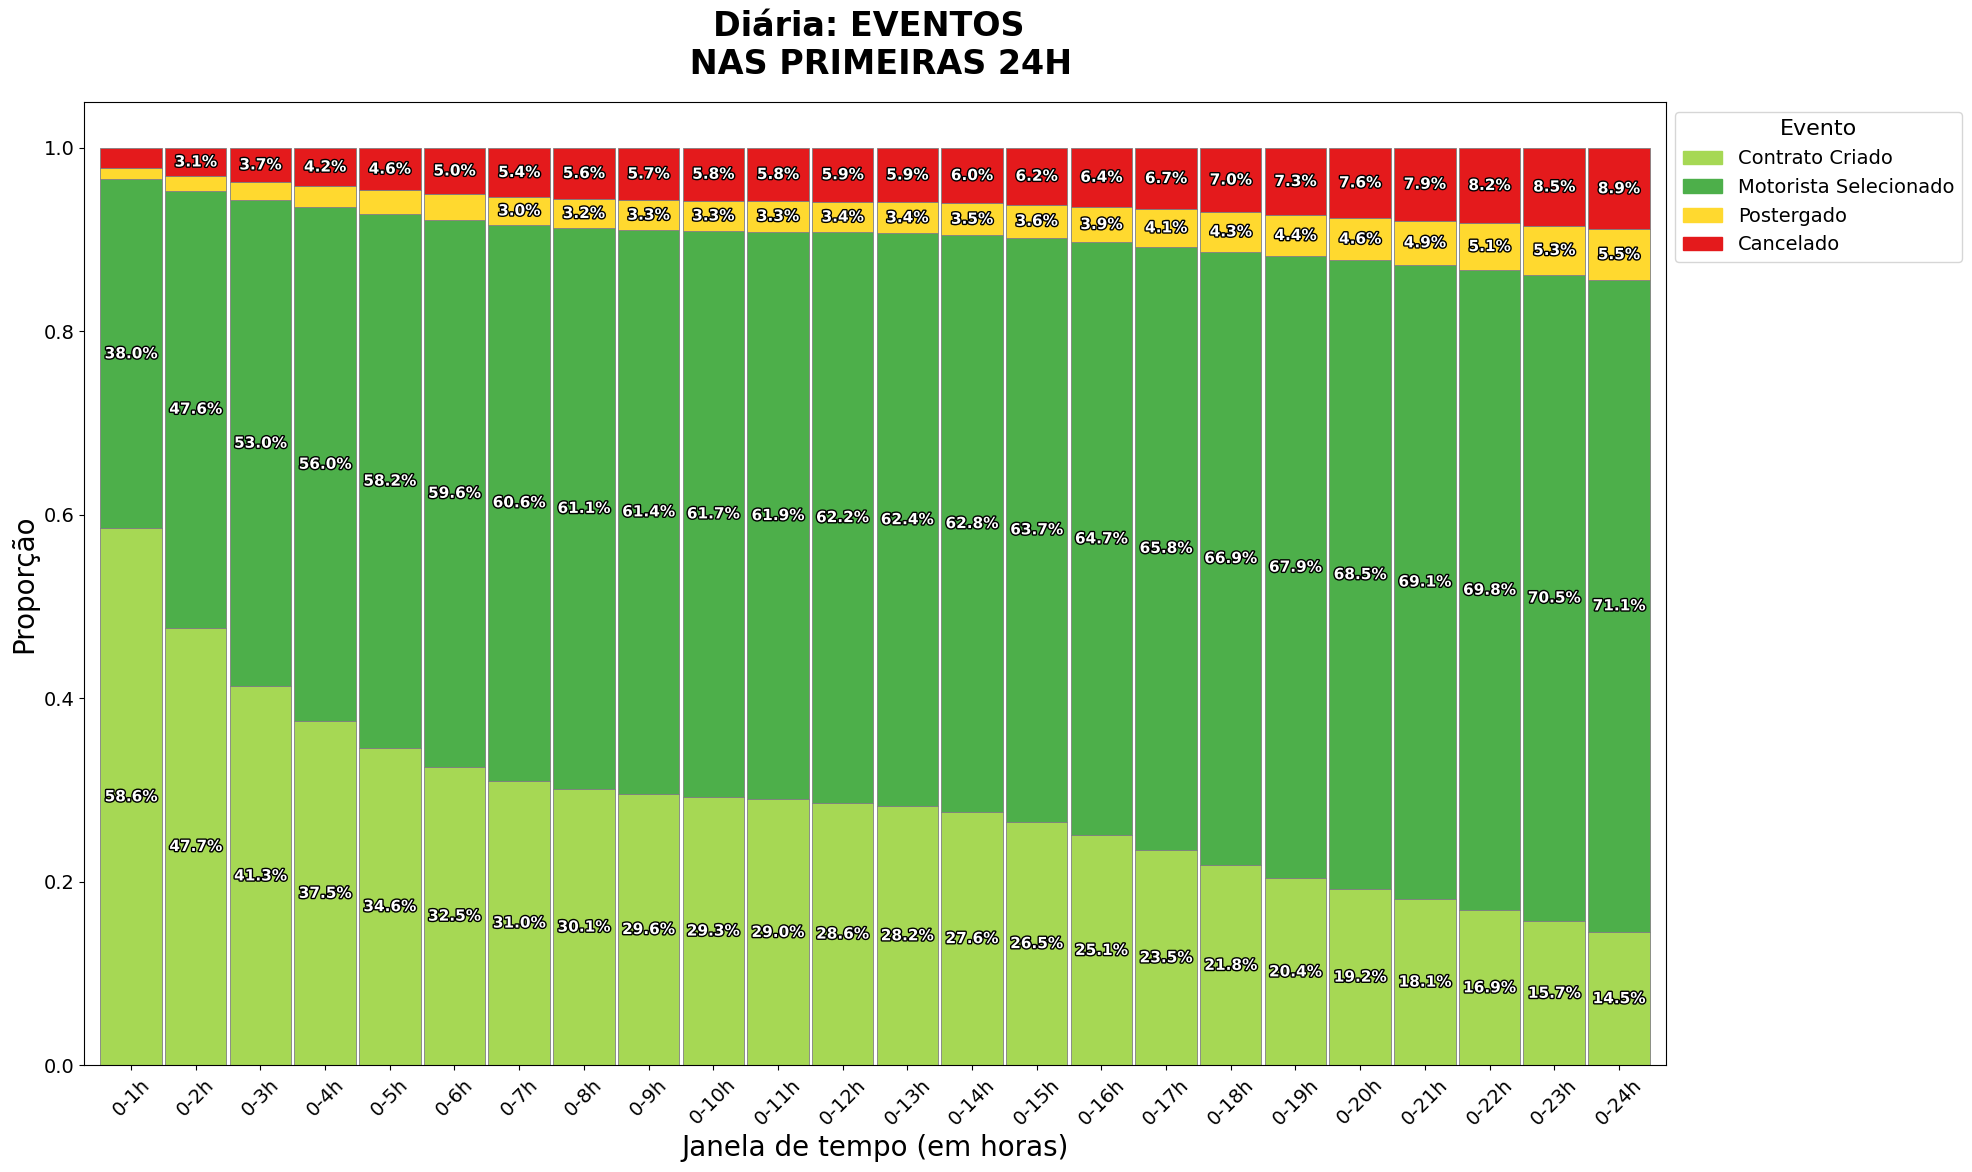

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

# ─── Dados ───
df = dfs["B - timeline"].copy()
df['created_at'] = pd.to_datetime(df['created_at'])
df['event_date'] = pd.to_datetime(df['event_date'])
df['tempo_decorrido'] = pd.to_numeric(df['tempo_decorrido'], errors='coerce')

# ─── Janelas de tempo (1h a 24h) ───
janelas_horas = list(range(1, 25, 1))
df_resultados = []

for h in janelas_horas:
    df_janela = df[df['tempo_decorrido'] <= h].copy()
    df_ultimos = df_janela.sort_values('event_date').groupby('id').tail(1)
    df_ultimos['janela'] = f'0-{h}h'
    df_resultados.append(df_ultimos)

df_final = pd.concat(df_resultados, ignore_index=True)
ordem_janelas = [f'0-{h}h' for h in janelas_horas]
df_final['janela'] = pd.Categorical(df_final['janela'], categories=ordem_janelas, ordered=True)

# ─── Proporções ───
tabela_proporcao = (
    df_final.groupby(['janela', 'event_name'])
    .size()
    .unstack(fill_value=0)
    .loc[ordem_janelas]
)
tabela_pct = tabela_proporcao.div(tabela_proporcao.sum(axis=1), axis=0)

# ─── Cores e nomes ───
cores_eventos = {
    'freight_created': '#a6d854',
    'has_driver': '#4daf4a',
    'start_at_change': '#ffd92f',
    'canceled': '#e41a1c'
}
nomes_portugues = {
    'freight_created': 'Contrato Criado',
    'has_driver': 'Motorista Selecionado',
    'start_at_change': 'Postergado',
    'canceled': 'Cancelado'
}
ordem_eventos = ['freight_created', 'has_driver', 'start_at_change', 'canceled']
tabela_pct = tabela_pct[[col for col in ordem_eventos if col in tabela_pct.columns]]
colors = [cores_eventos[col] for col in tabela_pct.columns]

# ─── Gráfico ───
fig, ax = plt.subplots(figsize=(20, 12))
fig.patch.set_facecolor('white')
tabela_pct.plot(
    kind='bar',
    stacked=True,
    ax=ax,
    color=colors,
    edgecolor='gray',
    linewidth=0.6,
    width=0.95  # ← barras mais largas e próximas
)

# ─── Porcentagens com estilo uniforme ───
for i, (index, row) in enumerate(tabela_pct.iterrows()):
    y_offset = 0
    for col in tabela_pct.columns:
        pct = row[col]
        if pct > 0.03:
            ax.text(
                i,
                y_offset + pct / 2,
                f"{pct * 100:.1f}%",
                ha='center',
                va='center',
                fontsize=11,
                fontweight='bold',
                color='white',
                path_effects=[path_effects.withStroke(linewidth=2, foreground='black')]
            )
        y_offset += pct


ax.set_title(f'{TIPO}: EVENTOS \n NAS PRIMEIRAS 24H', fontsize=24, fontweight='bold', pad=20)
ax.set_xlabel('Janela de tempo (em horas)', fontsize=20)
ax.set_ylabel('Proporção', fontsize=20)
ax.tick_params(axis='x', labelsize=14, rotation=45)
ax.tick_params(axis='y', labelsize=14)

# ─── Legenda em português ───
handles = [plt.Rectangle((0, 0), 1, 1, color=cores_eventos[col]) for col in tabela_pct.columns]
labels_pt = [nomes_portugues[col] for col in tabela_pct.columns]
ax.legend(
    handles=handles,
    labels=labels_pt,
    title='Evento',
    title_fontsize=16,
    fontsize=14,
    loc='upper left',
    bbox_to_anchor=(1, 1)
)

plt.tight_layout()
plt.show()


/tmp/ipykernel_11791/2096388592.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_final.groupby(['janela', 'event_name'])


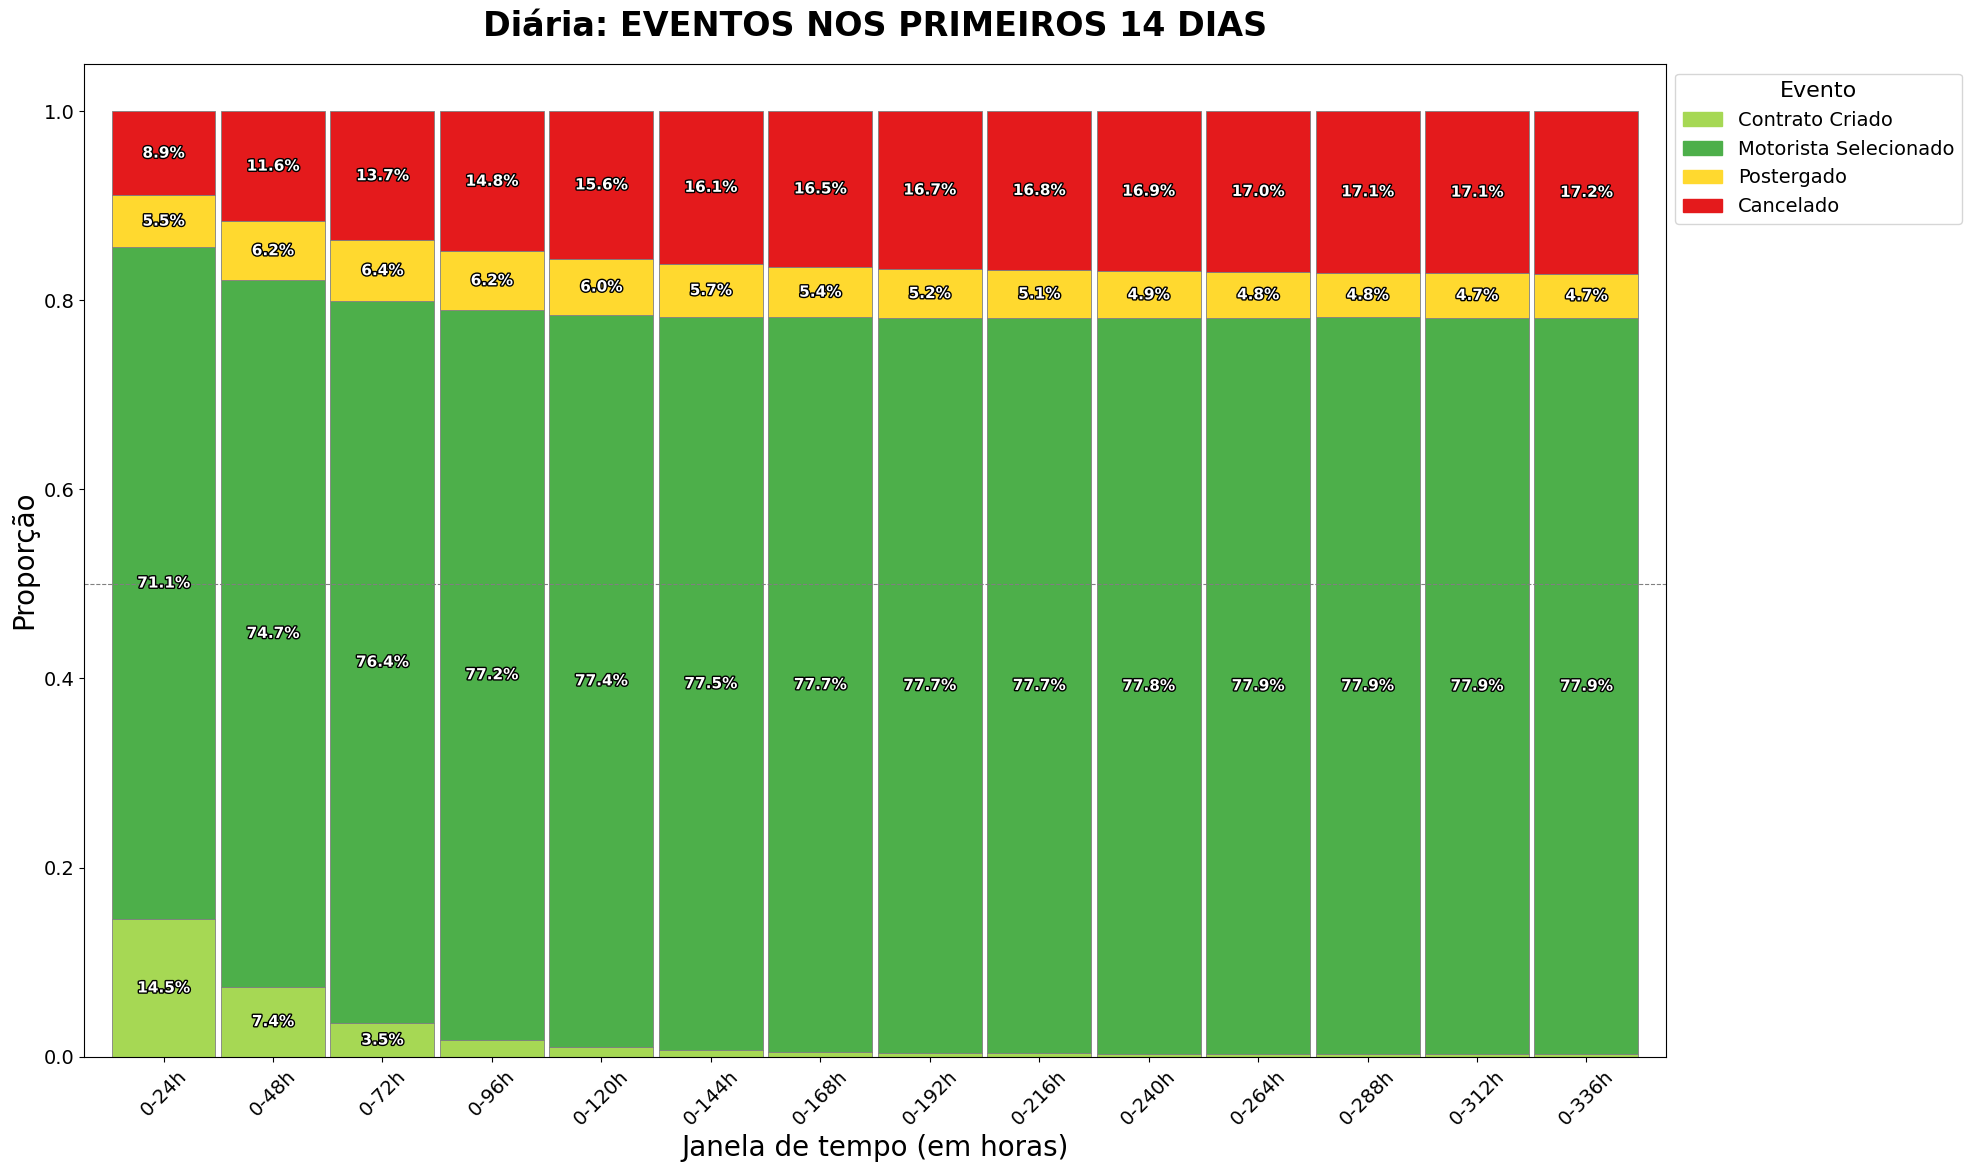

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

# ─── Preparação dos Dados ───
df = dfs["B - timeline"].copy()
df['created_at'] = pd.to_datetime(df['created_at'])
df['event_date'] = pd.to_datetime(df['event_date'])
df['tempo_decorrido'] = pd.to_numeric(df['tempo_decorrido'], errors='coerce')

# ─── Janelas de tempo (até 14 dias) ───
janelas_horas = list(range(24, 14 * 25, 24))  # de 24h até 336h
df_resultados = []

for h in janelas_horas:
    df_janela = df[df['tempo_decorrido'] <= h].copy()
    df_ultimos = df_janela.sort_values('event_date').groupby('id').tail(1)
    df_ultimos['janela'] = f'0-{h}h'
    df_resultados.append(df_ultimos)

df_final = pd.concat(df_resultados, ignore_index=True)
ordem_janelas = [f'0-{h}h' for h in janelas_horas]
df_final['janela'] = pd.Categorical(df_final['janela'], categories=ordem_janelas, ordered=True)

# ─── Proporções ───
tabela_proporcao = (
    df_final.groupby(['janela', 'event_name'])
    .size()
    .unstack(fill_value=0)
    .loc[ordem_janelas]
)
tabela_pct = tabela_proporcao.div(tabela_proporcao.sum(axis=1), axis=0)

# ─── Cores e nomes ───
cores_eventos = {
    'freight_created': '#a6d854',
    'has_driver': '#4daf4a',
    'start_at_change': '#ffd92f',
    'canceled': '#e41a1c'
}
nomes_portugues = {
    'freight_created': 'Contrato Criado',
    'has_driver': 'Motorista Selecionado',
    'start_at_change': 'Postergado',
    'canceled': 'Cancelado'
}
ordem_eventos = ['freight_created', 'has_driver', 'start_at_change', 'canceled']
tabela_pct = tabela_pct[[col for col in ordem_eventos if col in tabela_pct.columns]]
colors = [cores_eventos[col] for col in tabela_pct.columns]

# ─── Gráfico ───
fig, ax = plt.subplots(figsize=(20, 12))
fig.patch.set_facecolor('white')
tabela_pct.plot(
    kind='bar',
    stacked=True,
    ax=ax,
    color=colors,
    edgecolor='gray',
    linewidth=0.6,
    width=0.95
)

# ─── Porcentagens 100% brancas com contorno ───
for i, (index, row) in enumerate(tabela_pct.iterrows()):
    y_offset = 0
    for col in tabela_pct.columns:
        pct = row[col]
        if pct > 0.03:
            ax.text(
                i,
                y_offset + pct / 2,
                f"{pct * 100:.1f}%",
                ha='center',
                va='center',
                fontsize=11,
                fontweight='bold',
                color='white',
                path_effects=[path_effects.withStroke(linewidth=2, foreground='black')]
            )
        y_offset += pct

# ─── Linha de referência ───
ax.axhline(0.5, color='gray', linestyle='--', linewidth=0.8)

ax.set_title(f'{TIPO}: EVENTOS NOS PRIMEIROS 14 DIAS', fontsize=24, fontweight='bold', pad=20)
ax.set_xlabel('Janela de tempo (em horas)', fontsize=20)
ax.set_ylabel('Proporção', fontsize=20)
ax.tick_params(axis='x', labelsize=14, rotation=45)
ax.tick_params(axis='y', labelsize=14)

# ─── Legenda ───
handles = [plt.Rectangle((0, 0), 1, 1, color=cores_eventos[col]) for col in tabela_pct.columns]
labels_pt = [nomes_portugues[col] for col in tabela_pct.columns]
ax.legend(
    handles=handles,
    labels=labels_pt,
    title='Evento',
    title_fontsize=16,
    fontsize=14,
    loc='upper left',
    bbox_to_anchor=(1, 1)
)

plt.tight_layout()
plt.show()
